In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
# generates training data
def gen_data(num_data, seed = 2024):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    # u = torch.rand(1)
    data_fn_obj = lambda x,y: torch.cos(2*x)*torch.cos(y) + torch.sin(x) # toy function
    latent_fn_obj = data_fn_obj(x, y)
    z_obj = latent_fn_obj.squeeze()
    data_fn_cnt = lambda x, y: torch.cos(x)*torch.cos(y) - torch.sin(x)*torch.sin(y)
    latent_fn_cnt = data_fn_cnt(x, y)
    z_cnt = torch.heaviside(latent_fn_cnt - 0.5, torch.zeros(latent_fn_cnt.shape)).long().squeeze()
    return torch.cat((x,y),dim=1), z_obj, z_cnt, data_fn_obj, data_fn_cnt

In [3]:
# generate training data - y= objective values, c=class label
train_x, train_y, train_c, genfn_obj, genfn_cnt = gen_data(25)

# test data generate - uniform across [-3, 3] x [-3, 3]
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x1_mat, test_x2_mat = np.meshgrid(test_d1, test_d2)
test_x1_mat, test_x2_mat = torch.Tensor(test_x1_mat), torch.Tensor(test_x2_mat)

test_x = torch.cat((test_x1_mat.view(-1,1), test_x2_mat.view(-1,1)), dim=1)
test_y = genfn_obj(test_x1_mat, test_x2_mat)
test_y = test_y.view(-1)
test_latent_cnt = genfn_cnt(test_x1_mat, test_x2_mat)
test_labels = torch.heaviside(test_latent_cnt - 0.5, torch.zeros(test_latent_cnt.shape))
test_c = test_labels.view(-1)

In [4]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [5]:
# GP class for regression
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# GP class for classification
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# function to optimize parameters of the classification GP - 
def train_cls_gp(model, likelihood, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        if i + 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    return model, likelihood


In [7]:
# function to optimize parameters of the regression GP -
def train_reg_gp(model, likelihood, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i + 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood 

In [8]:
#initialize likelihood and model - regression
reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
reg_model = ExactGPModel(train_x, train_y, reg_likelihood)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

In [9]:
print("Training Regression model")
reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, 50)
print("Training Classification model")
cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, 50)

Training Regression model
Training Classification model


In [10]:
# prediction - objective values
reg_model.eval()
reg_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obj_pred = reg_likelihood(reg_model(test_x))
    obj_pred_means = obj_pred.loc
    obj_pred_stddev = obj_pred.stddev

    lower, upper = obj_pred.confidence_region()
    lower, upper = lower.reshape((20, 20)), upper.reshape((20, 20))

In [11]:
# prediction - class probabilities
cls_model.eval()
cls_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    logit_dist = cls_model(test_x)
    logit_means = logit_dist.loc
    logit_stddevs = logit_dist.stddev

# calculate probabilites from the logit values
samples = logit_dist.sample(torch.Size((256,))).exp()
class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

/Users/gouravkumbhojkar/miniconda3/envs/myenv/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/gouravkumbhojkar/miniconda3/envs/myenv/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


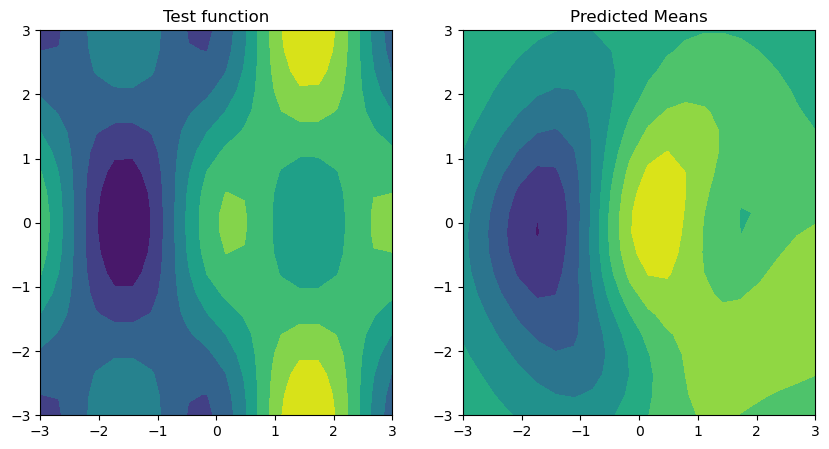

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

im = ax[0].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), genfn_obj(test_x1_mat, test_x2_mat))
ax[0].set_title('Test function')


ax[1].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_pred_means.reshape((20, 20)))
ax[1].set_title('Predicted Means')

plt.show()

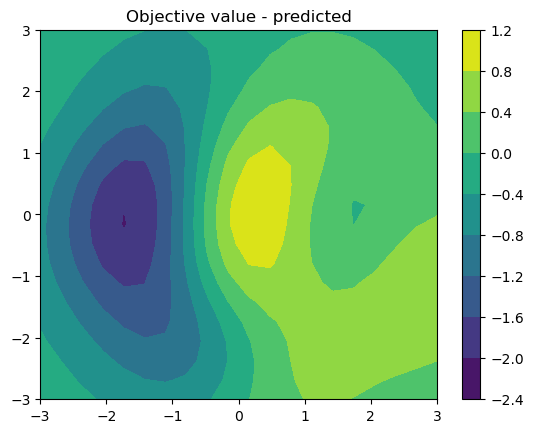

In [13]:
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_pred_means.numpy().reshape((20,20)))
plt.title("Objective value - predicted")
plt.colorbar()
plt.show()

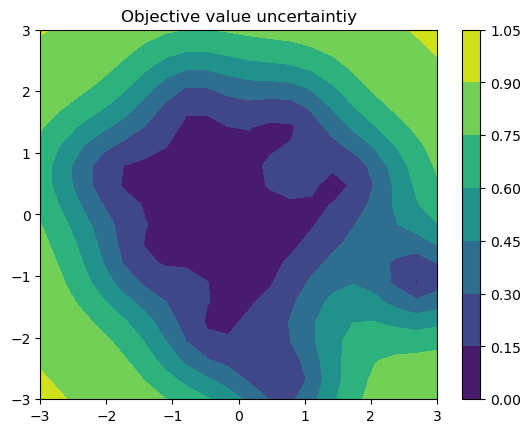

In [14]:
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_pred_stddev.numpy().reshape((20,20)))
plt.title("Objective value uncertaintiy")
plt.colorbar()
plt.show()

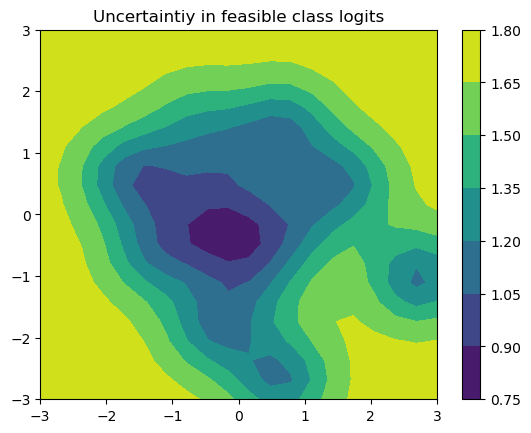

In [15]:
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), logit_stddevs[0].numpy().reshape((20,20)))
plt.title("Uncertaintiy in feasible class logits")
plt.colorbar()
plt.show()

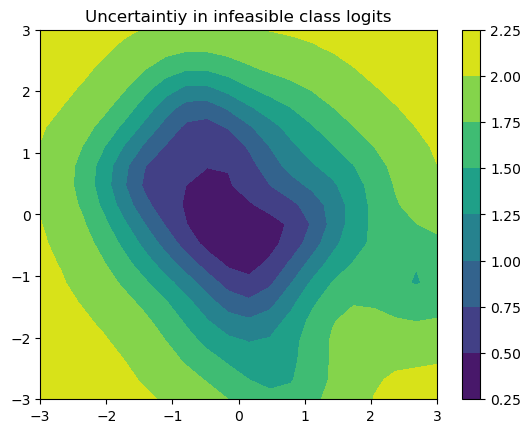

In [16]:
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), logit_stddevs[1].numpy().reshape((20,20)))
plt.title("Uncertaintiy in infeasible class logits")
plt.colorbar()
plt.show()

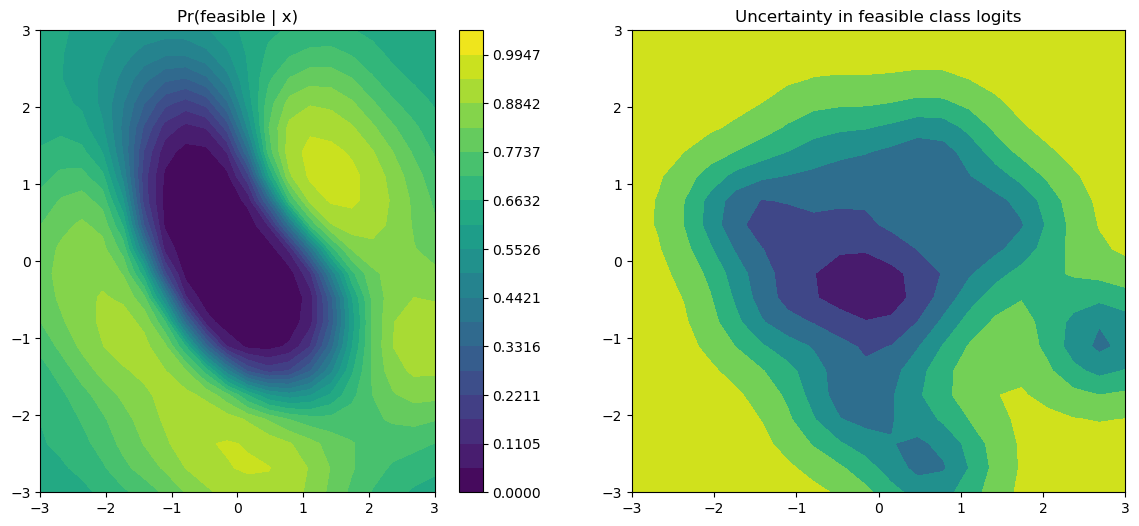

In [17]:
# feasible class probabilities
levels = np.linspace(0, 1.05, 20)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

im = ax[0].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), class_probabilites[0].numpy().reshape((20,20)), levels=levels)
ax[0].set_title('Pr(feasible | x)')
fig.colorbar(im, ax=ax[0])

ax[1].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), logit_stddevs[0].numpy().reshape((20,20)))
ax[1].set_title('Uncertainty in feasible class logits')
# fig.colorbar(im, ax=ax[1])

plt.show()

In [18]:
# calculate acquisition function
# Expected improvement, maximizing y
def calculate_acf(pred_mean, pred_std, y_max):
    improve = y_max - pred_mean
    z_score = np.divide(improve, pred_std + 1e-9)
    acf = np.multiply(improve, norm.cdf(z_score)) + np.multiply(pred_std, norm.pdf(z_score))
    return acf

# find the min objective value in training points
best_idx = np.argmin(train_y)
x_best = train_x[best_idx, :]
y_best = train_y[best_idx]

ei = calculate_acf(obj_pred_means, obj_pred_stddev, y_best)

In [19]:
y_best

tensor(-1.7976)

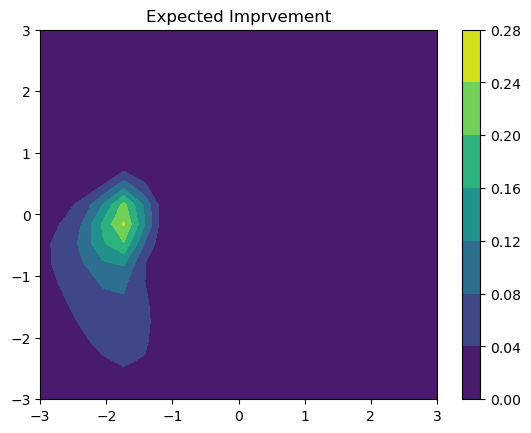

In [20]:
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), ei.numpy().reshape((20,20)))
plt.colorbar()
plt.title("Expected Imprvement")
plt.show()

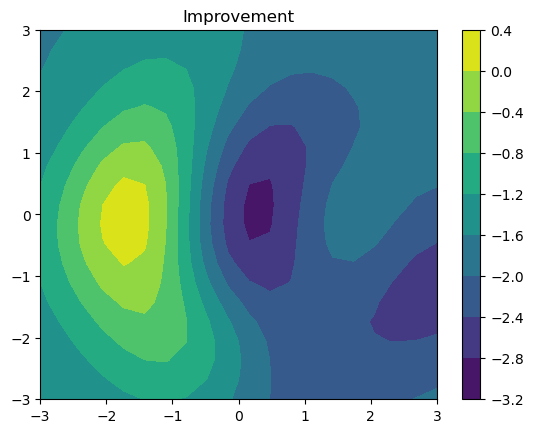

In [21]:
improve = y_best - obj_pred_means
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), improve.numpy().reshape((20,20)))
plt.title("Improvement")
plt.colorbar()
plt.show()

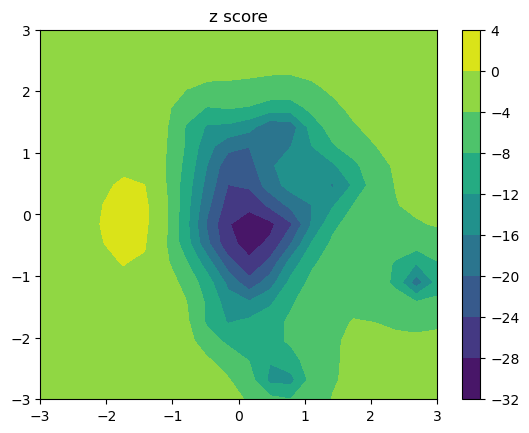

In [22]:
z_score = np.divide(improve, obj_pred_stddev + 1e-9)
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), z_score.numpy().reshape((20,20)))
plt.title("z score")
plt.colorbar()
plt.show()

In [23]:
# constrained EI calculation - feasibility aware
con_ei = class_probabilites[0] * ei

# top 5 candidate points from constrained ei
top5_ind = np.argpartition(con_ei, -5)[-5:]
top5_ind = top5_ind[np.argsort(con_ei[top5_ind])]


#objective function observation at best candidates
candidate_x2_ind = top5_ind%20
candidate_x1_ind = ((top5_ind - candidate_x2_ind)/20)

cnd_x = test_x[top5_ind, :]

In [24]:
top5_ind

tensor([163, 183, 204, 164, 184])

In [25]:
top5_obj_vals = genfn_obj(cnd_x[:,0], cnd_x[:,1])
latent_fn_cnt = genfn_cnt(cnd_x[:,0], cnd_x[:,1])
z_cnt = torch.heaviside(latent_fn_cnt - 0.5, torch.zeros(latent_fn_cnt.shape)).long().squeeze()
train_c = torch.cat((train_c, z_cnt), dim=0)

In [26]:
top5_obj_vals

tensor([-1.3938, -1.4496, -1.9198, -1.8275, -1.9198])

In [27]:
train_x = torch.cat((train_x, cnd_x), dim=0)
train_y = torch.cat((train_y, top5_obj_vals), dim=0)

remove_ind = top5_ind[-1]
test_x = torch.cat((test_x[:remove_ind, :], test_x[remove_ind+1:, :]))
test_y = torch.cat((test_y[:remove_ind], test_y[remove_ind+1:]))

In [28]:
#update GP
reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
reg_model = ExactGPModel(train_x, train_y, reg_likelihood)
cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood,num_classes=cls_likelihood.num_classes)

reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, 50)
cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, 50)

In [29]:
reg_model.eval()
reg_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obj_pred = reg_likelihood(reg_model(test_x))
    obj_pred_means = obj_pred.loc
    obj_pred_stddev = obj_pred.stddev
    
#prediction - class probabilities
cls_model.eval()
cls_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    logit_dist = cls_model(test_x)
    logit_means = logit_dist.loc
    logit_stddevs = logit_dist.stddev

# calculate probabilites from the logit values
samples = logit_dist.sample(torch.Size((256,))).exp()
class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

best_idx = np.argmin(train_y)
x_best = train_x[best_idx, :]
y_best = train_y[best_idx]

ei = calculate_acf(obj_pred_means, obj_pred_stddev, y_best)

con_ei = class_probabilites[0] * ei

# top 5 candidate points from constrained ei
top5_ind = np.argpartition(con_ei, -5)[-5:]
top5_ind = top5_ind[np.argsort(con_ei[top5_ind])]


#objective function observation at best candidates
candidate_x2_ind = top5_ind%20
candidate_x1_ind = ((top5_ind - candidate_x2_ind)/20)

cnd_x = test_x[top5_ind, :]

top5_obj_vals = genfn_obj(cnd_x[:,0], cnd_x[:,1])
latent_fn_cnt = genfn_cnt(cnd_x[:,0], cnd_x[:,1])

In [31]:
top5_obj_vals

tensor([-0.5460, -0.5482, -1.9324, -1.9324, -1.9198])

In [32]:
latent_fn_cnt

tensor([-0.9454, -0.7974,  0.3028, -0.0082, -0.0082])

In [33]:
class_probabilites[0][top5_ind]

tensor([0.8989, 0.8582, 0.8089, 0.9392, 0.9822])

In [36]:
remove_ind = top5_ind[-1]
test_x2 = torch.cat((test_x[:remove_ind, :], test_x[remove_ind+1:, :]))
test_x2.shape

torch.Size([399, 2])